In [1]:
import numpy as np
import pickle as pk
import pandas as pd

from PIL import Image, ImageDraw

import matplotlib
from matplotlib import cm
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

norm = matplotlib.colors.Normalize(vmin=1, vmax=3)
cmap = matplotlib.cm.get_cmap('viridis')

root = r"C:\tmp\OwnCloud\docs\neuroconnlab\dist_model\git\\"

c:\tmp\tools\Python38\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# plotting functions

In [2]:

from brainspace.utils.parcellation  import map_to_labels, reduce_by_labels
from lib.plotting import infer_colorbar,  paste_centrally, fig2tightPIL
import hcp_utils as hcp
from surfplot import Plot
from neuromaps.datasets import fetch_fslr
import numpy as np
from matplotlib.lines import Line2D

surfaces = fetch_fslr()
lh, rh = surfaces['inflated']

from brainspace.datasets  import load_parcellation

"""def show_pdata(data, ld = None, is_32k=False, cmap="coolwarm", mw_val=0, title=None, **kwargs):
  out = data if ld is None else map_to_labels(data, ld, mask=ld!=mw_val, fill=0)
  lcd = hcp.left_cortex_data(out) if not is_32k else out;
  p = Plot(surf_lh=lh, size=(800, 300))
  pkwargs = dict(cmap=cmap, cbar=True);
  pkwargs.update(kwargs)
  p.add_layer({'left': lcd},  **pkwargs)
  fig = p.build()
  if not(title is None): fig.axes[0].set_title(title)
  #fig.show()
  return fig""";


def show_pdata(data, ld = None, is_32k=False, cmap="coolwarm", mw_val=0, outline=None, title=None, outline_cmap = "Reds", plot_kwargs = {}, **kwargs):
  out = data if ld is None else map_to_labels(data, ld, mask=ld!=mw_val, fill=0)
  lcd = hcp.left_cortex_data(out) if not is_32k else out;
  pkw = dict(surf_lh=lh, size=(800, 300), zoom=1.7)
  pkw.update(plot_kwargs)
  p = Plot(**pkw)
  lkw = dict(cmap=cmap, cbar=True);
  lkw.update(kwargs)
  p.add_layer({'left': lcd},  **lkw)
  if not(outline is None):
    out2 = outline if ld is None else map_to_labels(outline, ld, mask=ld!=mw_val, fill=0)
    ocd = hcp.left_cortex_data(out2) if not is_32k else out2;
    p.add_layer({'left': ocd}, cmap=outline_cmap, as_outline=True, cbar=False)
  fig = p.build()
  if not(title is None): fig.axes[0].set_title(title)
  #fig.show()
  return fig


import io, PIL
def fig2pil(fig, pad_inches=-0.0, close=False):
  buf = io.BytesIO()
  fig.savefig(buf, bbox_inches="tight", pad_inches=pad_inches);
  buf.seek(0)
  ret = PIL.Image.open(buf);
  if close: plt.close(fig)
  return ret

def add_cbar(xx, data, uc=0.8, lc=0,cmap="viridis", **kwargs):
  jargs = dict(cmap=cmap, aspect=12, shrink=0.18)
  jargs.update(kwargs)
  cb = infer_colorbar(data, **jargs);
  cbimg = fig2tightPIL(cb.ax.get_figure(), dpi=100, format="png", close_fig=1)
  return img2

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [3]:
def subplot_grid(n_rows, n_cols, cw=7, rh="auto", axis_off=True, flat_axes=False, **kwargs):
  if rh=="auto": rh = cw *0.428;
  fig_args = dict(figsize=((n_cols)*cw, rh*n_rows))
  fig_args.update(kwargs)
  fig, axs = plt.subplots(n_rows,n_cols, **fig_args)
  faxs = axs.flatten()
  if axis_off:
    for i in range(len(faxs)): faxs[i].axis("off");
  return fig, (faxs if flat_axes else axs);



from PIL import Image, ImageDraw 
def image_grid(imgs, rows, cols, size=None, pad=0.01):
    assert len(imgs) <= rows*cols
    imgw, imgh = imgs[0].size if size is None else size
    pw,ph = int(imgw*pad), int(imgh*pad);
    w, h = imgw+pw, imgh+ph;

    grid = PIL.Image.new('RGBA', size=(cols*(w), rows*(h)))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        ew, eh = imgw-img.size[0], 2*(imgh-img.size[1]) # 2* to align at bottom
        #print(w,h,ew,eh)
        #grid.paste(img, box=(i%cols*w, i//cols*h))
        #print((i%cols*w)+0.5*(pw+ew))
        grid.paste(img, box=((i%cols*w)+int(0.5*(pw+ew)), (i//cols*h)+int(0.5*(ph+eh))))
    return grid



def add_patches(ax, cmap="viridis", titles=["real", "predicted", "overlap"], mm=(1,3), **kwargs):
  leg_kwargs = dict(loc='lower center')
  leg_kwargs.update(kwargs)
  cmap = cm.get_cmap(cmap)
  norm = mplcolors.Normalize(vmin=mm[0], vmax=mm[1])
  patches = []
  for i, label in enumerate(titles):
    patches.append(mpatches.Patch(color=cmap(norm(i+1)), label=label))
    ax.legend(handles=patches, **leg_kwargs)

In [4]:
percentile = 90
dice_fn = lambda ground_truth, prediction : np.sum(prediction[ground_truth==1])*2.0 / (np.sum(prediction) + np.sum(ground_truth))

def threshold_map(brain_map, percentile, binary = False, binary_val = 1):
  
  threshold = np.percentile(brain_map, percentile)
  mask = brain_map >= threshold;
  #if binary: return mask;
  brainmap_thres = np.zeros_like(brain_map)
  brainmap_thres[mask] = binary_val if binary else brain_map[mask] 
  return brainmap_thres;

def get_best_differentiated_subj_ids(y_test_pred, y_test, v=False):
  n_subjs= y_test.shape[0]; 
  n_tasks = y_test.shape[2]; 
  
  # dd indxes how well each subject is differentiated from all others on a per task basis
  dd = np.zeros((n_tasks, n_subjs))
  
  for tn in range(n_tasks): 
    corr_mat = np.corrcoef(y_test[:,:,tn],y_test_pred[:,:, tn])
    corr_mat = corr_mat[:n_subjs,n_subjs:]
    #plt.matshow(corr_mat)
  
    diagonal_corrs = np.diag(corr_mat);
    corr_tmp=corr_mat.copy()
    np.fill_diagonal(corr_tmp, np.nan)
    avg_cross_corrs = np.nanmean(corr_tmp,axis=0); 
    dd[tn, :] = (diagonal_corrs- avg_cross_corrs)

  best = np.argsort(dd, axis=1)[:, ::-1]
  best_across_tasks = np.argsort(dd.mean(axis=0))[::-1]
  if v: print("Best 10 differentiated subjects across tasks:", best_across_tasks[:10])
  return dd, best, best_across_tasks

# load the nessesary data and info

In [5]:
# get the scores from the regression result data 

regr_data = np.load("results/scores/linear_regression_scores_and_info_v3.yfull.aa.extended.small.npy", allow_pickle=1).item()
print(regr_data.keys(), "\n", regr_data['RS-PCA200'].keys())

regr_data_sm = np.load("results/scores/linear_regression_scores_and_info_v3.yfull.aa.npy", allow_pickle=1).item()
print(regr_data_sm.keys(), "\n", regr_data_sm['RS-PCA200'].keys())
cdict = {k: v["scoresd"] for k,v in regr_data_sm.items()}
ddict = {k: v["diff_scores_test"] for k,v in regr_data_sm.items()}

c:\tmp\tools\Python38\lib\site-packages\sklearn\base.py:299: UserWarning: Trying to unpickle estimator LinearRegression from version 1.0.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


dict_keys(['RS-PCA200', 'FS-StructuralMaps']) 
 dict_keys(['scoresd', 'diff_scores_test', 'y_test', 'y_test_pred', 'skr', 'sub_test'])
dict_keys(['RS-PCA200', 'RS-ICA200', 'SC Blueprints', 'Distance to Parcels (raw)', 'SEmodes', 'Distance-PCAgra', 'FS-StructuralMaps']) 
 dict_keys(['scoresd', 'diff_scores_test', 'isubjs', 'skr'])


In [6]:
subjs = regr_data['RS-PCA200']["sub_test"]
len(subjs)

51

In [7]:
unique_contrasts = np.loadtxt("data/task_contrasts_47_unique_names.txt", dtype=str);
ctrtasks = [uc.split("_")[0] for uc in unique_contrasts]
unique_tasks = np.unique(ctrtasks)
contr = {t:n for n,t in enumerate(unique_tasks)}
tasks_ids = [contr[t] for t in ctrtasks]
task_start_x = [np.where(np.array(tasks_ids)==n)[0][0] for n in np.unique(tasks_ids)]
task_mid_x = [np.where(np.array(tasks_ids)==n)[0].mean() for n in np.unique(tasks_ids)]

task_x = np.array([0, 3, 6, 14, 22, 25, 37])-0.3
uniq_tasks = ['EMOT', 'GAMBL', 'LANG', 'MOTOR', 'RELA', 'SOCIAL', 'WM']
contrast_ids_to_show = [8, 38, 16, 2, 27, 24, 5, 44, 21]
tnames = ["Lang", "WM2", "Motor Cue", "Emoti", "SocTOM", "Rel", "GRew" ,"WMFace", "MotorT"]
tnames_mid = ["Lang S-M", "WM2-0", "Motor Cue-Avg", "Emoti Face-Shape", "Social TOM-Rand", "Rel-Match", "Gamble Rew-Pun" ,"WM Face-Av", "Motor T-Avg"]

In [8]:
# Get the retest data
fn = "results/retest_hcp40.task_maps47.zscored.npy"
payload = np.load(fn, allow_pickle=1).item()
print(payload.keys())
tdata = payload["test_data"]
rdata = payload["retest_data"]

unique_contrasts2 = payload["info"]["unique_contrasts"]
subjs_retest_subset = payload["info"]["full_rt_subjs"]
zscore = payload["info"]["zscore"]
print("Loaded data:", zscore, tdata.shape)

overlap_subjs = [s for s in subjs if s in subjs_retest_subset ]
print(overlap_subjs)
index_in_big = [list(subjs).index(s) for s in overlap_subjs]
index_in_rts = [list(subjs_retest_subset).index(s) for s in overlap_subjs]
print(len(index_in_big),index_in_big)
print(len(index_in_rts),index_in_rts)

dict_keys(['info', 'test_data', 'retest_data'])
Loaded data: True (40, 29696, 47)
['562345', '599671', '660951']
3 [1, 14, 26]
3 [31, 32, 34]


# Individual Prediction Examples

In [9]:
modality = 'RS-PCA200'
y_test = regr_data[modality]['y_test']
y_test_pred = regr_data[modality]['y_test_pred']
subjs = regr_data[modality]['sub_test']

# getting the mean task maps as reference
mean_task_maps = np.load(root + "results/retest_hcp40.test.mean_task_maps47.from_zscored.npy", allow_pickle=1).item()["mean_task_maps"]
print(mean_task_maps.shape)

# getting the best differentiated subjects per task contrast
_, best, best_across_tasks = get_best_differentiated_subj_ids(y_test, y_test_pred, v=1)

(29696, 47)
Best 10 differentiated subjects across tasks: [21 12 18 13 27  0 17  9 47  6]


**plot some raw examples**

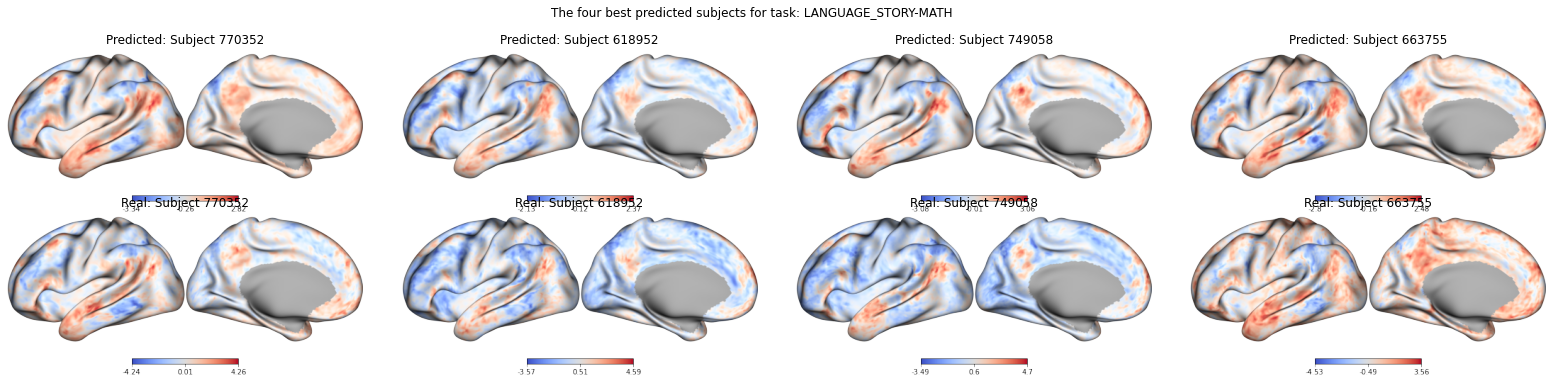

In [10]:
tn = list(unique_contrasts).index("LANGUAGE_STORY-MATH")

fig, axs = subplot_grid(2, 4, cw=7)
fig.suptitle(f"The four best predicted subjects for task: {unique_contrasts[tn]}")
for i, sn in enumerate(best[tn, :4]):
  axs[0,i].imshow(fig2pil(show_pdata(y_test_pred[sn,:,tn]), close=1))
  axs[0,i].set_title(f"Predicted: Subject {subjs[sn]}")
  axs[1,i].imshow(fig2pil(show_pdata(y_test[sn,:,tn]), close=1))
  axs[1,i].set_title(f"Real: Subject {subjs[sn]}")
plt.subplots_adjust(wspace=0.04, hspace=0);
#plt.tight_layout()

In [12]:
plt.close('all')

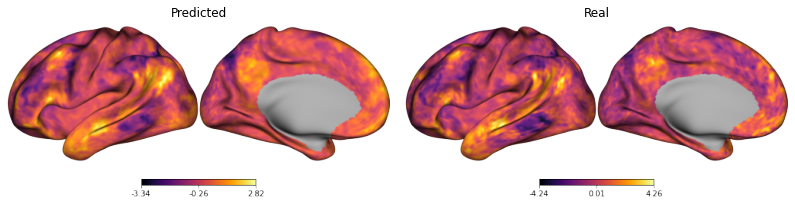

In [13]:
# Define the subject and task to plot 
tn = list(unique_contrasts).index("LANGUAGE_STORY-MATH") # =8
sn = best[tn, 0]
percentile = 90

# Plot the grid
fig, axs = subplot_grid(1, 2, cw=7, rh=7*0.6)
f = show_pdata(y_test_pred[sn, :, tn], cmap="inferno", ld = None)
axs[0].imshow(fig2pil(f, close=1)); axs[0].set_title("Predicted");
f = show_pdata(y_test[sn, :, tn], cmap="inferno", ld = None)
axs[1].imshow(fig2pil(f, close=1)); axs[1].set_title("Real");
plt.subplots_adjust(wspace=0.04, hspace=0); 

## Thresholded maps and overlaps (dice-scores)

**plotting thresholded maps**

(51, 29696, 47)


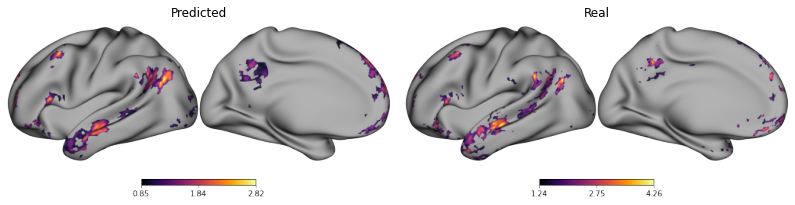

In [15]:
# Define the subject and task to plot 
tn = list(unique_contrasts).index("LANGUAGE_STORY-MATH") # =8
sn = best[tn, 0]
percentile = 90

# Shape of the task map data
print(y_test_pred.shape)

# Get the thresholded maps
ground_truth = threshold_map(y_test[sn, :, tn], percentile)
prediction = threshold_map(y_test_pred[sn, :, tn], percentile)

# Plot the grid
fig, axs = subplot_grid(1, 2, cw=7, rh=7*0.6)
f = show_pdata(prediction, cmap="inferno", ld = None)
axs[0].imshow(fig2pil(f, close=1)); axs[0].set_title("Predicted");
f = show_pdata(ground_truth, cmap="inferno", ld = None)
axs[1].imshow(fig2pil(f, close=1)); axs[1].set_title("Real");
plt.subplots_adjust(wspace=0.04, hspace=0); 

In [35]:
plt.close("all")

**calculation of dice score**

In [17]:
# Get the binarized thresholded maps
ground_truth = threshold_map(y_test[sn, :, tn], percentile, binary=1, binary_val=1)
prediction = threshold_map(y_test_pred[sn, :, tn], percentile, binary=1, binary_val=1)

# get the thresholded group mean map as reference
group_map_thres = threshold_map(mean_task_maps[:, tn], percentile, binary=1, binary_val=1)

# compute the dice-score
dice = dice_fn(ground_truth, prediction)
#from lib.stats import comp_dice ??comp_dice
print("Computed dice score:", dice)

Computed dice score: 0.5791245791245792


**plotting of the overlap**

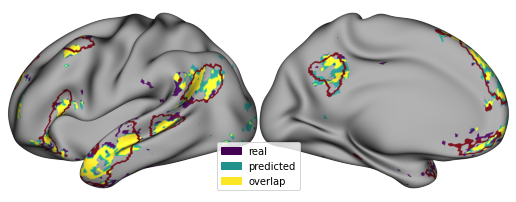

In [18]:
combined_map = ground_truth + (prediction*2)

f = show_pdata(combined_map, cmap="viridis", ld = None, cbar=None, outline=group_map_thres)
patches = []
for i, label in enumerate(["real", "predicted", "overlap"]):
  patches.append(mpatches.Patch(color=cmap(norm(i+1)), label=label))
  
legend = plt.legend(handles=patches, loc='lower center')
#plt.title(f"{unique_contrasts[tn]} for Subject {subjs[sn]}, dice={np.round(dice,2)}"); #plt.gca().set_title("dada");


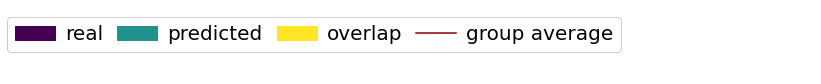

In [83]:

fig, axs = subplot_grid(1, 2, cw=3)
axs[0].legend(handles=patches, ncol=5, fontsize=20, framealpha=1, borderpad=0.4, handletextpad=0.5, columnspacing=0.7)
#plt.axis("off")

**dice scores for all test-subjects**

In [19]:
tn = list(unique_contrasts).index("LANGUAGE_STORY-MATH")
print("Dice scores ...\nreal-pred\treal-group\tpred-group")
group_map_thres = threshold_map(mean_task_maps[:, tn], percentile, binary=1, binary_val=1)

res = np.zeros((len(y_test), 3))

for sn in range(len(y_test)):
    
    real_map_thres = threshold_map(y_test[sn, :, tn], percentile, binary=1, binary_val=1)
    pred_map_thres = threshold_map(y_test_pred[sn, :, tn], percentile, binary=1, binary_val=1)

    d1 = dice_fn(real_map_thres, pred_map_thres).round(3)
    d3 = dice_fn(real_map_thres, group_map_thres).round(3)
    d4 = dice_fn(pred_map_thres, group_map_thres).round(3)
    res[sn,:]= d1,d3,d4
    if sn < 15: print(d1, "\t\t", d3, "\t\t", d4);

d1,d3,d4 = res.mean(axis=0).round(3)
print("-------")
print(d1, "\t\t", d3, "\t\t", d4);

Dice scores ...
real-pred	real-group	pred-group
0.465 		 0.423 		 0.561
0.375 		 0.428 		 0.53
0.651 		 0.502 		 0.504
0.344 		 0.403 		 0.518
0.498 		 0.551 		 0.587
0.652 		 0.585 		 0.628
0.605 		 0.524 		 0.574
0.505 		 0.497 		 0.543
0.506 		 0.535 		 0.533
0.733 		 0.59 		 0.639
0.176 		 0.123 		 0.49
0.457 		 0.416 		 0.571
0.476 		 0.419 		 0.526
0.658 		 0.595 		 0.556
0.659 		 0.58 		 0.575
-------
0.541 		 0.509 		 0.56


## Overlap real, predicted and retest (3 subjects)

(there is just 3 of such subjects)

In [29]:
# calculate dice scores

tn = list(unique_contrasts).index("LANGUAGE_STORY-MATH")
print("Dice scores ...\nreal-pred\treal-retest\treal-group\tpred-group\treal-test\tretest-pred ")

for i in range(len(index_in_big)):
    sn = index_in_big[i]
    real_map_thres = threshold_map(y_test[sn, :, tn], percentile, binary=1, binary_val=1)
    pred_map_thres = threshold_map(y_test_pred[sn, :, tn], percentile, binary=1, binary_val=1)

    rtsn = index_in_rts[i]
    retest_map_thres = threshold_map(rdata[rtsn, :, tn], percentile, binary=1, binary_val=1)
    test_map_thres = threshold_map(tdata[rtsn, :, tn], percentile, binary=1, binary_val=1)

    group_map_thres = threshold_map(mean_task_maps[:, tn], percentile, binary=1, binary_val=1)

    
    d1 = dice_fn(real_map_thres, pred_map_thres).round(3)
    d2 = dice_fn(real_map_thres, retest_map_thres).round(3)
    d3 = dice_fn(real_map_thres, group_map_thres).round(3)
    d4 = dice_fn(pred_map_thres, group_map_thres).round(3)
    d5 = dice_fn(real_map_thres, test_map_thres).round(3)
    d6 = dice_fn(retest_map_thres, pred_map_thres).round(3)

    print(d1, "\t\t", d2, "\t\t", d3, "\t\t", d4, "\t\t", d5, "\t\t", d6);

Dice scores ...
real-pred	real-retest	real-group	pred-group	real-test	retest-pred 
0.375 		 0.322 		 0.428 		 0.53 		 1.0 		 0.363
0.659 		 0.637 		 0.58 		 0.575 		 1.0 		 0.655
0.509 		 0.576 		 0.488 		 0.532 		 1.0 		 0.498


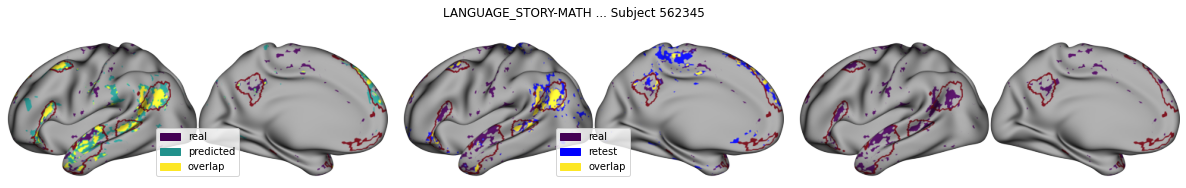

In [22]:
from matplotlib import colors as mplcolors
sn = index_in_big[0]
real_map_thres = threshold_map(y_test[sn, :, tn], percentile, binary=1, binary_val=1)
pred_map_thres = threshold_map(y_test_pred[sn, :, tn], percentile, binary=1, binary_val=1)
rtsn = index_in_rts[0]
retest_map_thres = threshold_map(rdata[rtsn, :, tn], percentile, binary=1, binary_val=1)
test_map_thres = threshold_map(tdata[rtsn, :, tn], percentile, binary=1, binary_val=1)

fig, axs = subplot_grid(1, 3, cw=7)
fig.suptitle(f"{unique_contrasts[tn]} ... Subject {subjs[sn]}")

combined_map = real_map_thres + (pred_map_thres*2)
f = show_pdata(combined_map, cmap="viridis", cbar=None,outline=group_map_thres)
axs[0].imshow(fig2pil(f, close=1))
add_patches(axs[0], cmap="viridis", titles=["real", "predicted", "overlap"])

combined_map = real_map_thres + (retest_map_thres*2)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#440154","blue", "#FDE725"])
#f = show_pdata(combined_map, cmap="inferno", cbar=None,outline=group_map_thres, color_range=(0.65,3))
f = show_pdata(combined_map, cmap=cmap, cbar=None, outline=group_map_thres)
axs[1].imshow(fig2pil(f, close=1))
#add_patches(axs[1], cmap="inferno", titles=["real", "retest", "overlap"], mm=(0.65,3))
add_patches(axs[1], cmap=cmap, titles=["real", "retest", "overlap"])

combined_map = real_map_thres + (test_map_thres*2)
f = show_pdata(combined_map, cmap="viridis", cbar=None,outline=group_map_thres)
axs[2].imshow(fig2pil(f, close=1))

plt.subplots_adjust(wspace=0.04, hspace=0);
#plt.tight_layout()

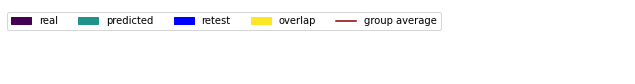

In [23]:

norm = mplcolors.Normalize(vmin=0, vmax=2)
patches = []
colors = ["#440154", "#21918C", "blue", "#FDE725"]
labels = ["real", "predicted", "retest", "overlap"]

for l,c in zip(labels, colors):
  patches.append(mpatches.Patch(color=c, label=l))

patches.append(Line2D([0], [0], label='group average', color='darkred'))

fig, axs = subplot_grid(1, 2, cw=3)
axs[0].legend(handles=patches, ncol=5)
#axs[0].legend(handles=patches, ncol=1)
plt.show()

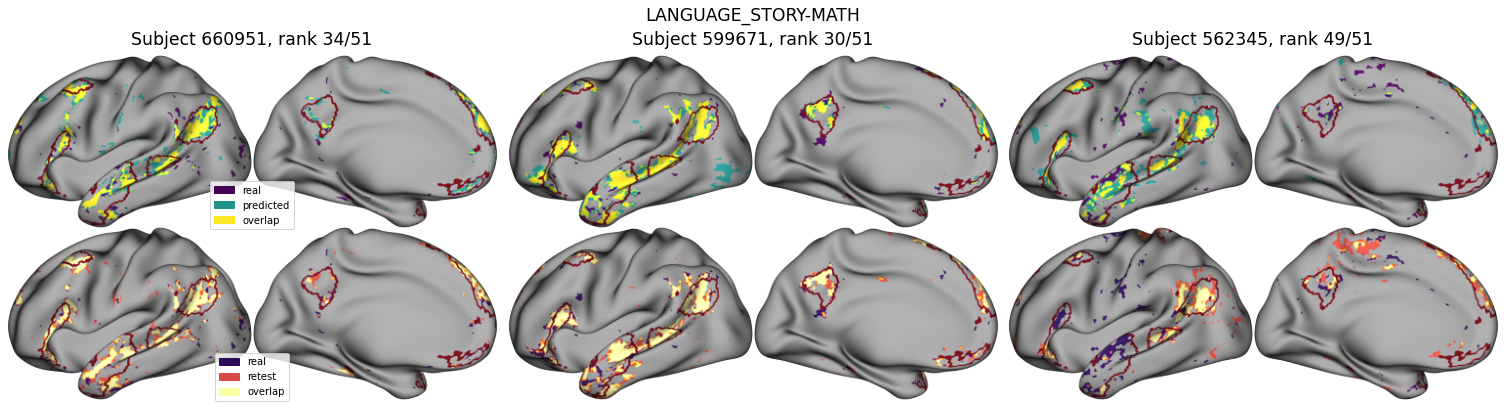

In [24]:
fig, axs = subplot_grid(2, 3, cw=7)
fig.suptitle(f"{unique_contrasts[tn]}", size="xx-large")

## for each column, one subject
for i in range(3):

    sn = index_in_big[::-1][i]
    
    ## precalculation of thresholded maps
    real_map_thres = threshold_map(y_test[sn, :, tn], percentile, binary=1, binary_val=1)
    pred_map_thres = threshold_map(y_test_pred[sn, :, tn], percentile, binary=1, binary_val=1)
    rtsn = index_in_rts[::-1][i]
    retest_map_thres = threshold_map(rdata[rtsn, :, tn], percentile, binary=1, binary_val=1)
    test_map_thres = threshold_map(tdata[rtsn, :, tn], percentile, binary=1, binary_val=1)

    ## Real vs Predicted
    combined_map = real_map_thres + (pred_map_thres*2)
    f = show_pdata(combined_map, cmap="viridis", cbar=None,outline=group_map_thres)
    axs[0,i].imshow(fig2pil(f, close=1))
    n =list(best[tn]).index(sn) +1 
    axs[0,i].set_title(f"Subject {subjs[sn]}, rank {n}/{len(best[tn])}", size="xx-large");

    ## Real vs retest

    combined_map = test_map_thres + (retest_map_thres*2)
    f = show_pdata(combined_map, cmap="inferno", cbar=None,outline=group_map_thres, color_range=(0.65,3))
    axs[1,i].imshow(fig2pil(f, close=1))

add_patches(axs[0, 0], cmap="viridis", titles=["real", "predicted", "overlap"])
add_patches(axs[1, 0], cmap="inferno", titles=["real", "retest", "overlap"], mm=(0.65,3))

plt.subplots_adjust(wspace=0.04, hspace=-0.3);
plt.tight_layout()

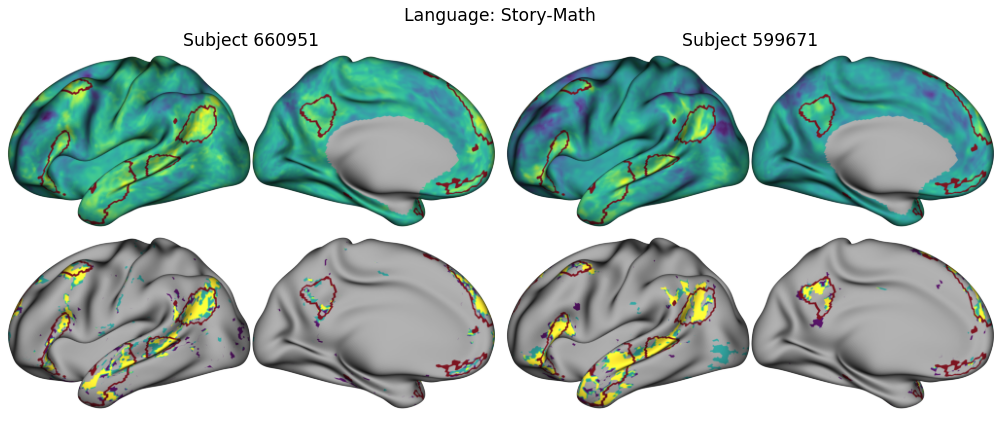

In [25]:
#fig, axs = subplot_grid(3, 2, cw=7)
fig, axs = subplot_grid(2, 2, cw=7)
title=unique_contrasts[tn].replace("_", ": ").lower().title()
fig.suptitle(f"{title}", size="xx-large")

group_map_thres = threshold_map(mean_task_maps[:, tn], percentile, binary=1, binary_val=1)


## for each column, one subject
for i in range(2):

    sn = index_in_big[::-1][i]
    
    ## precalculation of thresholded maps
    real_map_thres = threshold_map(y_test[sn, :, tn], percentile, binary=1, binary_val=1)
    pred_map_thres = threshold_map(y_test_pred[sn, :, tn], percentile, binary=1, binary_val=1)
    rtsn = index_in_rts[::-1][i]
    retest_map_thres = threshold_map(rdata[rtsn, :, tn], percentile, binary=1, binary_val=1)
    test_map_thres = threshold_map(tdata[rtsn, :, tn], percentile, binary=1, binary_val=1)

    ## Show predicted maps
    predmap = y_test_pred[sn, :, tn]
    f = show_pdata(predmap, cmap="viridis", cbar=None,outline=group_map_thres)
    axs[0,i].imshow(fig2pil(f, close=1))
    n =list(best[tn]).index(sn) +1 
    axs[0,i].set_title(f"Subject {subjs[sn]}", size="xx-large", verticalalignment="top");
    #axs[0,i].text(250,20+10, f"discriminability\nrank {n}/{len(best[tn])}", size="large", horizontalalignment="center");

    #if i==0:
    #    t= axs[0,i].text(0.0, 5, "Predicted", horizontalalignment ="left", size="xx-large")
    #    t.set_bbox(dict(facecolor='white', alpha=0.8, lw=0.3))

    ## Real vs Predicted
    combined_map = real_map_thres + (pred_map_thres*2)
    f = show_pdata(combined_map, cmap="viridis", cbar=None,outline=group_map_thres)
    axs[1,i].imshow(fig2pil(f, close=1))
    n =list(best[tn]).index(sn) +1 

    #if i==0:
    #    t= axs[1,i].text(0.0, 10, "Predicted vs Real", horizontalalignment ="left", size="xx-large")
    #    t.set_bbox(dict(facecolor='white', alpha=0.8, lw=0.3))

    ## Real vs retest
    """
    combined_map = test_map_thres + (retest_map_thres*2)
    f = show_pdata(combined_map, cmap="inferno", cbar=None,outline=group_map_thres, color_range=(0.65,3))
    axs[2,i].imshow(fig2pil(f, close=1))

    if i==0:
        t= axs[2,i].text(0.0, 10, "Real vs Retest", horizontalalignment ="left", size="xx-large")
        t.set_bbox(dict(facecolor='white', alpha=0.8, lw=0.3))

    """
"""
add_patches(axs[1, 0], cmap="viridis", titles=["real", "predicted", "overlap"])
patches = []
patches.append(mpatches.Patch(color=cm.get_cmap("viridis")(250), label="Predicted"))
patches.append(Line2D([0], [0], label='group average', color='darkred'))
axs[0, 0].legend(handles=patches, **dict(loc='lower center'))
#add_patches(axs[2, 0], cmap="inferno", titles=["real", "retest", "overlap"], mm=(0.65,3))
""";
plt.subplots_adjust(wspace=0.04, hspace=0)#-0.3);
plt.tight_layout()

[-2.81  2.07]


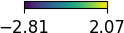

In [26]:
def make_cbar(data, uc=0.8, lc=0,cmap="viridis", force_ticks=False, **kwargs):
  jargs = dict(cmap=cmap, aspect=12, shrink=0.18)
  jargs.update(kwargs)
  cb = infer_colorbar(data, **jargs);
  if not (force_ticks is False):
    #v = np.abs(data).max();
    tick_vals = np.round([data.min(), data.max()], 2) if force_ticks==True else force_ticks;
    print(tick_vals)
    cb.set_ticks(tick_vals, labelsize=100); 
    cb.ax.tick_params(labelsize=12) 
    #cb.ax.get_xticklabels()[0].set_horizontalalignment('left')  
    #cb.ax.get_xticklabels()[-1].set_horizontalalignment('right')
  cbimg = fig2tightPIL(cb.ax.get_figure(), dpi=100, format="png", close_fig=1)
  return cbimg
  #img2 = paste_centrally(img, cbimg, lc=lc, uc=uc)
  #return img2

sn = index_in_big[::-1][0]
predmap = y_test_pred[sn, :, tn]
make_cbar(predmap, force_ticks=True)

In [27]:
plt.close("all")

## Zoomed Inset Overlap

for multiple tasks
also: export all vertex-wise maps and caluclate all parel-wise scores

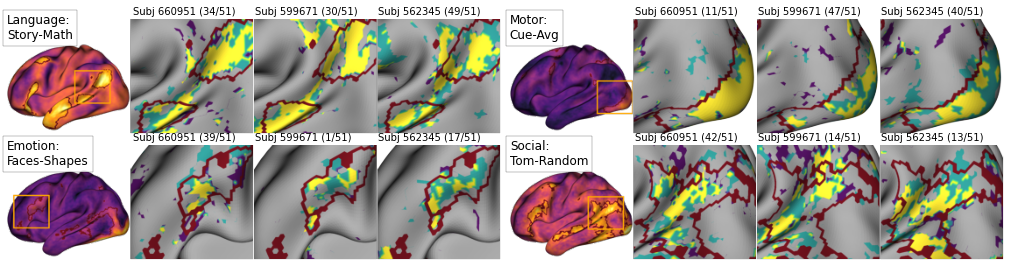

In [28]:
white_img = Image.new("RGB", (40, 40), (255, 255, 255))
fig, axs = subplot_grid(2, 2, cw=7, rh=1.8, flat_axes=1)

shapes = [(260, 110, 400, 240), (335, 150, 475, 280), (24, 105, 164, 235), (300, 110, 440, 240)]
for i, tn in enumerate([8 , 16, 2, 27]):
  group_map_thres = threshold_map(mean_task_maps[:, tn], percentile, binary=1, binary_val=1)
  imgs = []
  f = show_pdata(mean_task_maps[:, tn], cmap="inferno", cbar=None, outline=group_map_thres, plot_kwargs = dict(size=(1600, 600)))
  img = fig2pil(f, close=1);
  i1d = ImageDraw.Draw(img)  
  i1d.rectangle((shapes[i][:2], shapes[i][2:]), fill =None, outline ="orange", width=5) 
  w, h = img.size
  #print(img.size)
  img = img.crop((0,0, w/2, h))
  ratio = (w/2) /140 
  img = img.resize((140, int(h/ratio) ))
  imgs.append(img)
  
  headings = []
  for k in range(3):
    sn = index_in_big[::-1][k]
    rtsn = index_in_rts[::-1][k]

    real_map_thres = threshold_map(y_test[sn, :, tn], percentile, binary=1, binary_val=1)
    pred_map_thres = threshold_map(y_test_pred[sn, :, tn], percentile, binary=1, binary_val=1)
    combined_map = real_map_thres + (pred_map_thres*2)
    f = show_pdata(combined_map, cmap="viridis", cbar=None, outline=group_map_thres, plot_kwargs =dict(size=(1600, 600)))
    img = fig2pil(f, close=1);
    im = img.crop(shapes[i])
    imgs.append(im);
    
    n =list(best[tn]).index(sn) +1 
    headings.append(f"Subj {subjs[sn]} ({n}/{len(best[tn])})")
    #print(im.size)

  axs[i].imshow(image_grid(imgs, 1, 4, size=(140,130)))
  for k in range(3):
    axs[i].text(140*(k+1)+3, -5, headings[k], horizontalalignment="left")

  title=unique_contrasts[tn].replace("_", ":\n").lower().title()
  t = axs[i].set_title(title, loc="left",  x=0.0, y=0.775)
  #print(t)
  t.set_bbox(dict(facecolor='white', alpha=0.8, lw=0.3))
  #break;

plt.subplots_adjust(wspace=0.01, hspace=0);
plt.tight_layout(pad=0.3)
#out=fig2pil(plt.gcf(), close=1);
#plt.close("all")
#out

In [34]:
plt.close("all")

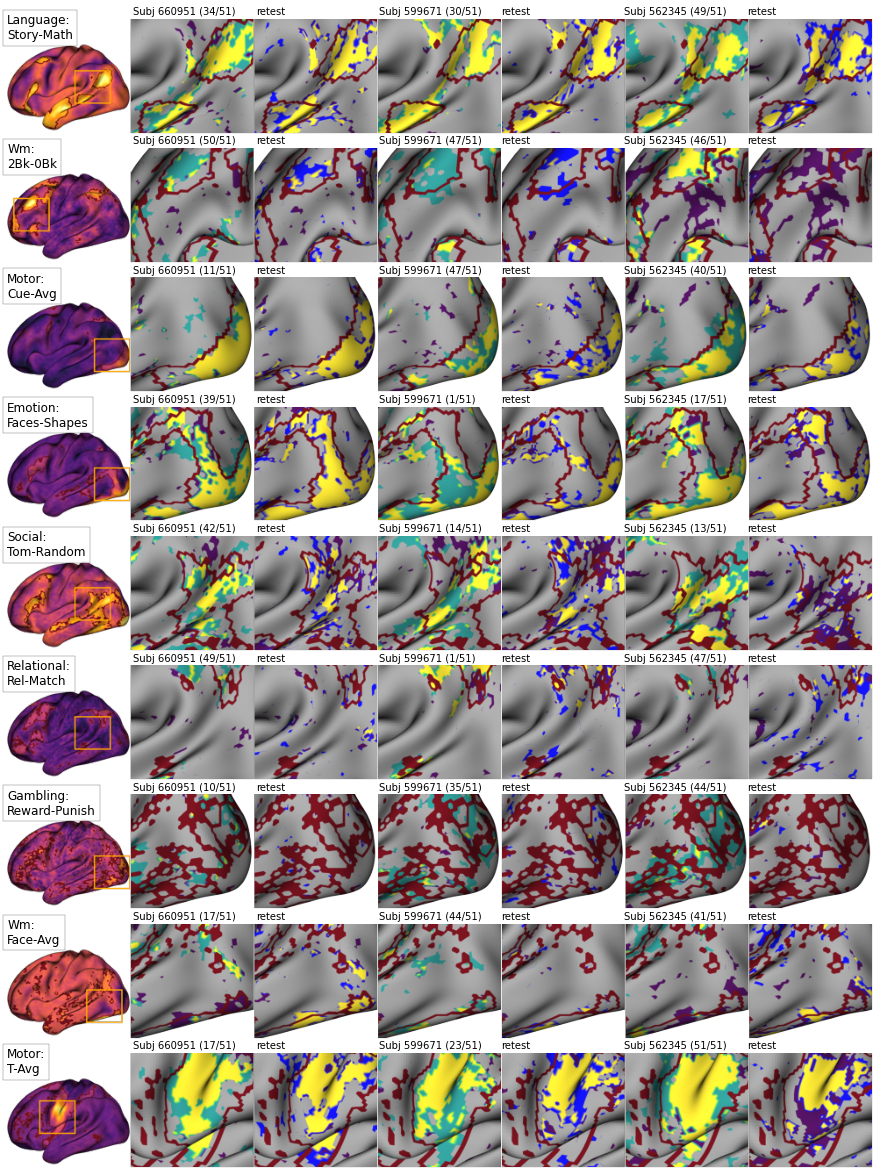

In [18]:
white_img = Image.new("RGB", (40, 40), (255, 255, 255))
fig, axs = subplot_grid(9, 1, cw=7*2, rh=1.8, flat_axes=1)
pkw = dict(size=(1600, 600))
retest_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#440154","blue", "#FDE725"])


#shapes = [(260, 110, 400, 240), (335, 150, 475, 280), (24, 105, 164, 235), (300, 110, 440, 240)]
#shapes = [(260, 110, 400, 240), (24, 105, 164, 235),  (335, 150, 475, 280), (335, 150, 475, 280)] + 5*[(24, 105, 164, 235)]
shapes = [(260, 110, 400, 240), (24, 105, 164, 235),  (335, 150, 475, 280), (335, 150, 475, 280)] +\
  [(260, 110, 400, 240), (260, 110, 400, 240), (335, 150, 475, 280), (305, 165, 445, 295), (124, 95, 264, 225)]

#for i, tn in enumerate([8 , 16, 2, 27]):
for i, tn in enumerate(contrast_ids_to_show):
  group_map_thres = threshold_map(mean_task_maps[:, tn], percentile, binary=1, binary_val=1)
  
  first_row_imgs = []
  second_row_imgs =[white_img]

  f = show_pdata(mean_task_maps[:, tn], cmap="inferno", cbar=None, outline=group_map_thres, plot_kwargs =pkw)
  img = fig2pil(f, close=1);
  i1d = ImageDraw.Draw(img)  
  i1d.rectangle((shapes[i][:2], shapes[i][2:]), fill =None, outline ="orange", width=5) 
  w, h = img.size
  #print(img.size)
  img = img.crop((0,0, w/2, h))
  ratio = (w/2) /140 
  img = img.resize((140, int(h/ratio) ))
  first_row_imgs.append(img)
  
  headings = []
  for k in range(3):
    sn = index_in_big[::-1][k]
    rtsn = index_in_rts[::-1][k]

    real_map_thres = threshold_map(y_test[sn, :, tn], percentile, binary=1, binary_val=1)
    pred_map_thres = threshold_map(y_test_pred[sn, :, tn], percentile, binary=1, binary_val=1)
    combined_map = real_map_thres + (pred_map_thres*2)
    f = show_pdata(combined_map, cmap="viridis", cbar=None, outline=group_map_thres, plot_kwargs =pkw)
    img = fig2pil(f, close=1);
    im = img.crop(shapes[i])
    first_row_imgs.append(im);
    
    retest_map_thres = threshold_map(rdata[rtsn, :, tn], percentile, binary=1, binary_val=1)
    combined_map = real_map_thres + (retest_map_thres*2)
    f = show_pdata(combined_map, cmap=retest_cmap, cbar=None, outline=group_map_thres, plot_kwargs =pkw)
    img = fig2pil(f, close=1);
    im = img.crop(shapes[i])
    first_row_imgs.append(im)
    
    n =list(best[tn]).index(sn) +1 
    headings.append(f"Subj {subjs[sn]} ({n}/{len(best[tn])})")
    headings.append("retest")
    #print(im.size)

  # plot first row
  axs[i].imshow(image_grid(first_row_imgs, 1, (3*2)+1, size=(140,130)))
  for k in range(len(headings)):
    axs[i].text(140*(k+1)+3, -5, headings[k], horizontalalignment="left")

  title=unique_contrasts[tn].replace("_", ":\n").lower().title()
  t = axs[i].set_title(title, loc="left",  x=0.0, y=0.775)
  t.set_bbox(dict(facecolor='white', alpha=0.8, lw=0.3))

  #axs[(2*i)+1].imshow(image_grid(second_row_imgs, 1, 4, size=(140,130)))


plt.subplots_adjust(wspace=0.01, hspace=0);
plt.tight_layout(pad=0.3)
#out=fig2pil(plt.gcf(), close=1);
#plt.close("all")
#out

In [73]:
plt.close("all")